In [1]:
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
import pyslha
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

## Validation of efficiencies for gluino pair production for the MS-AGNOSTIC search

### ATLAS Values (Tables 4, 6 and 10 from HepDATA)

In [2]:
atlasUL = np.genfromtxt('HEPData-ins1718558-v1-Table_10.csv',delimiter=',',
                        names=True,skip_header=27,skip_footer=45,usecols=(0,1))
atlasXsecs = np.genfromtxt('HEPData-ins1718558-v1-Table_10.csv',delimiter=',',
                        names=True,skip_header=78,usecols=(0,1))
atlasEffs = np.genfromtxt('HEPData-ins1718558-v1-Table_4.csv',delimiter=',',
                        names=True,skip_header=37,skip_footer=117-57,usecols=(1,2))
atlasSRs = np.genfromtxt('HEPData-ins1718558-v1-Table_6.csv',delimiter=',',
                        names=True,skip_header=86,skip_footer=104-92,usecols=(1,2,3))

### Recasting Values

In [3]:
# signalRegions = {'(mTOF>350, mdEdx > 300)' : [350.,300.], '(mTOF>350, mdEdx > 300)' : [550.,450.], 
#                  '(mTOF>700, mdEdx > 600)' : [700.,600.], '(mTOF>850, mdEdx > 750)' : [850.,750.]}
recastXsecs = []
recastEffs = []
for f in glob.glob('gluino_stable_*.slha'):
    slhaData = pyslha.readSLHAFile(f)
    mgluino = slhaData.blocks['MASS'][1000021]
    xsec = slhaData.xsections[2212,2212,1000021,1000021].get_xsecs(qcd_order=2)
    xsec = xsec[0].value*1000 #xsec in fb
    recastXsecs.append([mgluino,xsec])    
    
    with open(f.replace('.slha','.out'),'r') as effFile:
        effLines = [l for l in effFile.readlines() if "total Efficiency" in l]
        effs = []
        for l in effLines:
            SRlabel,eff = l.split('total Efficiency:')
            SRlabel = SRlabel.strip()
            eff = eval(eff)
            effs.append(eff)
        recastEffs.append([mgluino]+effs)
    
recastXsecs = np.array(sorted(recastXsecs))
recastEffs = np.array(sorted(recastEffs))

### Compare Efficiencies

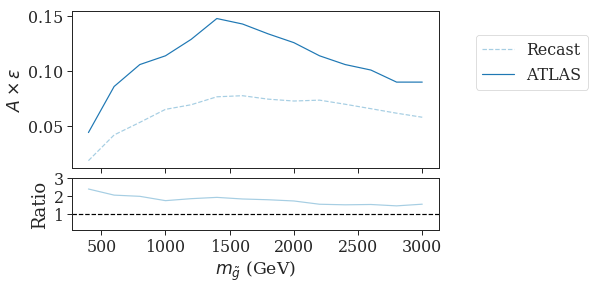

In [11]:
#Get maximum efficiencies
maxEffs = np.array(sorted([[pt[0],pt[1:].max()] for pt in recastEffs]))
atlasEffs.sort()

#Define subplots and their properties:
f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Plot curves
axarr[0].plot(maxEffs[:,0],maxEffs[:,1],'--',label='Recast')
axarr[0].plot(atlasEffs['MASS_GEV'],atlasEffs['ACC_X_EFF'],label='ATLAS')
axarr[0].set_ylabel(r'$A \times \epsilon$')

#Plot ratio
axarr[1].plot(atlasEffs['MASS_GEV'],atlasEffs['ACC_X_EFF']/maxEffs[:,1])
axarr[1].axhline(y=1.,c='black',linestyle='--')
axarr[1].set_ylabel('Ratio', fontsize=18) #Y-label
axarr[1].set_xlabel(r'$m_{\tilde{g}}$ (GeV)')
axarr[1].set_ylim(0.1,3.0)
axarr[0].legend(loc=(1.1,0.5))
# f.tight_layout()
plt.show()

### Compare Upper Limit

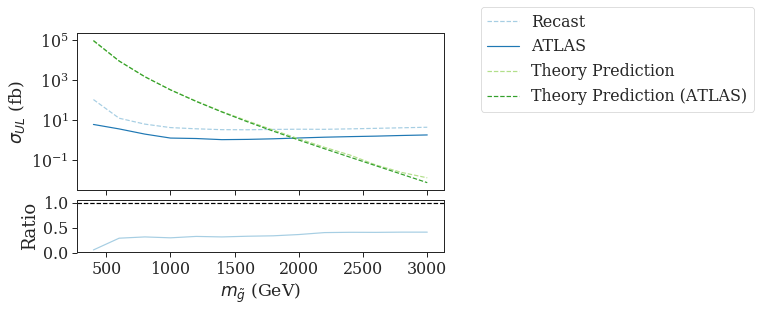

In [5]:
#Get recast upper limits
sigmaUL = []
atlasSRs.sort()
atlasUL.sort()
atlasXsecs.sort()
signalUL = np.array(atlasSRs['XSEC_X_ACC_X_EFF_FB']) #upper limits on the signal xsec*acc*eff (fb) for each SR
for pt in recastEffs:
    sigUL = max(signalUL/pt[1:])
    sigmaUL.append([pt[0],sigUL])
sigmaUL = np.array(sorted(sigmaUL))

#Define subplots and their properties:
f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Plot curves
axarr[0].plot(sigmaUL[:,0],sigmaUL[:,1],'--',label='Recast')
axarr[0].plot(atlasUL['TRUE_MASS_GEV'],atlasUL['OBS_LIMIT_MSAGNOSTIC_FB'],label='ATLAS')
axarr[0].plot(recastXsecs[:,0],recastXsecs[:,1],'--',label='Theory Prediction')
axarr[0].plot(atlasXsecs['TRUE_MASS_GEV'],atlasXsecs['THEORY_CROSSSECTION_FB'],'--',
              label='Theory Prediction (ATLAS)')
axarr[0].set_ylabel(r'$\sigma_{UL}$ (fb)')
axarr[0].set_yscale('log')

#Plot ratio
axarr[1].plot(atlasUL['TRUE_MASS_GEV'],atlasUL['OBS_LIMIT_MSAGNOSTIC_FB']/sigmaUL[:,1])
axarr[1].axhline(y=1.,c='black',linestyle='--')
axarr[1].set_ylabel('Ratio', fontsize=18) #Y-label
axarr[1].set_xlabel(r'$m_{\tilde{g}}$ (GeV)')
axarr[0].legend(loc=(1.1,0.5))
# f.tight_layout()
plt.show()

In [6]:
# f.savefig('validationPlot.png')